# Image Classification on the Simpsons

The simpsons dataset contains pictures of several characters on the Simpons. In this notebook, I will build a model to classify images using a convolutional neural network.

The dataset is taken from kaggle: https://www.kaggle.com/alexattia/the-simpsons-characters-dataset

In [1]:
import pandas as pd
import numpy as np
import os
import random
import shutil
import split_folders
import cv2
import functools
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model
from keras.metrics import top_k_categorical_accuracy
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense

Using TensorFlow backend.


## Step 1 - Explore the Dataset

In [2]:
char_dirs = glob('./datasets/simpsons_dataset/*')
characters = [char.split('/')[-1] for char in char_dirs]
n_chars = len(characters)

print("There are {0} characters in the dataset".format(n_chars))

There are 47 characters in the dataset


In [3]:
# get the number of images per character
img_counts = {}
all_images = []

for i in range(n_chars):
    imgs = glob(char_dirs[i]+'/*')
    all_images += imgs
    img_counts[characters[i]] = len(imgs)
    
img_counts = {k:v for k,v in sorted(img_counts.items(), key=lambda x: x[1])}
print("There are a total of {0} images in the dataset".format(len(all_images)))

There are a total of 20933 images in the dataset


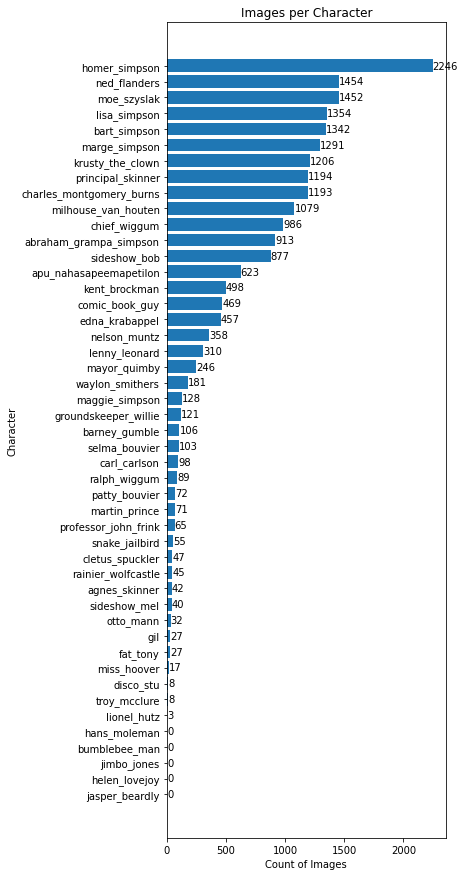

In [4]:
fig, ax = plt.subplots(figsize=[5,15])

ax.barh(list(img_counts.keys()), list(img_counts.values()), align='center')
ax.set_title('Images per Character')
ax.set_ylabel('Character')
ax.set_xlabel('Count of Images')

for k, v in img_counts.items():
    plt.text(x=v+1, y=k , s=v, verticalalignment='center')

plt.show()

In [5]:
# only keep classes with at least 350 images
MIN_IMG_CT = 350

CLASSES = [c for c,ct in img_counts.items() if ct > MIN_IMG_CT]
CLASSES.sort()
N_CLASSES = len(CLASSES)
    
print("There are {0} classes.".format(N_CLASSES))

There are 18 classes.


./datasets/simpsons_dataset/disco_stu/pic_0000.jpg
(432, 576, 3)


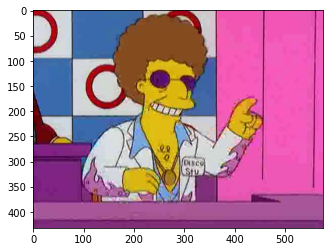

In [6]:
# display a random image
rdm_idx = random.choice([i for i,val in enumerate(characters) if img_counts[val]>0])
rand_char = characters[rdm_idx]
imgs = glob(char_dirs[rdm_idx]+'/*')
rand_img = imgs[random.randint(0, len(imgs))]
print(rand_img)

im = cv2.imread(rand_img)
print(im.shape)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2 - Preprocessing

First, define some parameters for how the images should be preprocessed:

In [7]:
IMG_SIZE = 300

#### Resize and Pad Images

Some images are horizontal and some are vertical. To make them all the same size and square, pad the images.

In [8]:
def pad_image(image_path, save_path, desired_size):
    
    # if padded file exists, quit
    if os.path.isfile(save_path):
        return
    
    im = Image.open(image_path)
    width, height = im.size

    if width > height:
        new_width = desired_size
        new_height = int(new_width * height / width)

    elif height >= width:
        new_height = desired_size
        new_width = int(new_height * width / height)

    im = im.resize((new_width, new_height), Image.ANTIALIAS)

    padded = Image.new('RGB',
                       (desired_size, desired_size),
                       (0, 0, 0))
    height_diff =  int((desired_size  - new_height)/2)
    width_diff = int((desired_size - new_width)/2)

    padded.paste(im, (width_diff,  height_diff))
    padded.save(save_path, 'PNG', quality=100)

In [9]:
# create a directories for the padded images
if not os.path.exists('./datasets/padded'):
    os.makedirs('./datasets/padded')

for char_dir in char_dirs:
    new_dir = char_dir.replace('simpsons_dataset', 'padded')
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

# saved padded images
for i in range(len(all_images)):
    save_file = all_images[i].replace('simpsons_dataset', 'padded')
    pad_image(all_images[i], save_file, IMG_SIZE)

(300, 300, 3)


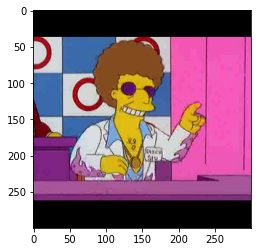

In [10]:
# view a padded image
im = cv2.imread(rand_img.replace('simpsons_dataset', 'padded'))
print(im.shape)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

#### Split data into Train and Val

In [11]:
# clear out old data
if os.path.exists('./datasets/data'):
    shutil.rmtree('./datasets/data')

os.makedirs('./datasets/data/train')
os.makedirs('./datasets/data/test')
os.makedirs('./datasets/data/val')



# undersample when splitting in train/test
imgs_per_class = min(v for k,v in img_counts.items() if k in CLASSES)
train_ratio = 0.8
val_ratio = 0.15
test_ratio = 0.05

for c in CLASSES:
    
    os.makedirs('./datasets/data/train/' + c)
    os.makedirs('./datasets/data/test/' + c)
    os.makedirs('./datasets/data/val/' + c)
    
    files = glob('./datasets/padded/'+c+'/*')

    np.random.shuffle(files)
    train_files = files[:int(train_ratio*imgs_per_class)]
    test_files = files[int(train_ratio*imgs_per_class):int((train_ratio+test_ratio)*imgs_per_class)]
    val_files = files[int((train_ratio+test_ratio)*imgs_per_class):imgs_per_class]
    
    for f in train_files:
        shutil.copy(f, f.replace('padded', 'data/train'))

    for f in val_files:
        shutil.copy(f, f.replace('padded', 'data/val'))

    for f in test_files:
        shutil.copy(f, f.replace('padded', 'data/test'))

## Step 3 - Data Augmentation & Model Prep

In [12]:
BATCH_SIZE = 32
IMG_DIM = 64

In [13]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
train_set = train_datagen.flow_from_directory(
    'datasets/data/train',
    target_size=(IMG_DIM, IMG_DIM),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

val_set = val_datagen.flow_from_directory(
    'datasets/data/val',
    target_size = (IMG_DIM, IMG_DIM),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=False
)

test_set = test_datagen.flow_from_directory(
    'datasets/data/test',
    target_size = (IMG_DIM, IMG_DIM),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle=False
)

Found 5148 images belonging to 18 classes.
Found 972 images belonging to 18 classes.
Found 324 images belonging to 18 classes.


In [15]:
class_indices = train_set.class_indices
print(class_indices)

{'abraham_grampa_simpson': 0, 'apu_nahasapeemapetilon': 1, 'bart_simpson': 2, 'charles_montgomery_burns': 3, 'chief_wiggum': 4, 'comic_book_guy': 5, 'edna_krabappel': 6, 'homer_simpson': 7, 'kent_brockman': 8, 'krusty_the_clown': 9, 'lisa_simpson': 10, 'marge_simpson': 11, 'milhouse_van_houten': 12, 'moe_szyslak': 13, 'ned_flanders': 14, 'nelson_muntz': 15, 'principal_skinner': 16, 'sideshow_bob': 17}


## Step 4 - Model

In [16]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(IMG_DIM,IMG_DIM,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=N_CLASSES, activation='softmax'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)        

## Step 5 - Compile and Fit

In [18]:
EPOCHS = 20

In [19]:
# use checkpoints to save the best model
cp = ModelCheckpoint(
    filepath = 'best_model.h5',
    monitor='val_loss',
    mode='min',
    verbose=0,
    save_best_only=True
)

In [20]:
# early stopping
es = EarlyStopping(
    monitor = 'val_loss',
    patience = 15
)

In [21]:
# use the top-2 accuracy as another metric
top2_acc = functools.partial(top_k_categorical_accuracy, k=2)
top2_acc.__name__ = 'top2_acc'

In [22]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy', top2_acc]
)

In [23]:
history = model.fit(
    train_set,
    validation_data = val_set,
    epochs = EPOCHS,
    callbacks=[cp, es]
    #class_weight = class_weights
)

Epoch 1/20
161/161 [==============================] - 78s 483ms/step - loss: 2.7009 - accuracy: 0.1399 - top2_acc: 0.2401 - val_loss: 2.5132 - val_accuracy: 0.2202 - val_top2_acc: 0.3570
Epoch 2/20
161/161 [==============================] - 74s 461ms/step - loss: 2.2003 - accuracy: 0.3300 - top2_acc: 0.4713 - val_loss: 0.8014 - val_accuracy: 0.4681 - val_top2_acc: 0.6101
Epoch 3/20
161/161 [==============================] - 77s 478ms/step - loss: 1.8063 - accuracy: 0.4555 - top2_acc: 0.6030 - val_loss: 0.7086 - val_accuracy: 0.5309 - val_top2_acc: 0.6759
Epoch 4/20
161/161 [==============================] - 72s 445ms/step - loss: 1.5579 - accuracy: 0.5334 - top2_acc: 0.6803 - val_loss: 0.7554 - val_accuracy: 0.5802 - val_top2_acc: 0.7377
Epoch 5/20
161/161 [==============================] - 72s 445ms/step - loss: 1.3453 - accuracy: 0.5983 - top2_acc: 0.7321 - val_loss: 0.2903 - val_accuracy: 0.6307 - val_top2_acc: 0.7613
Epoch 6/20
161/161 [==============================] - 69s 430ms/s

## Step 6 - Evaluate

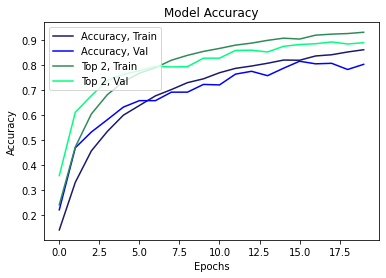

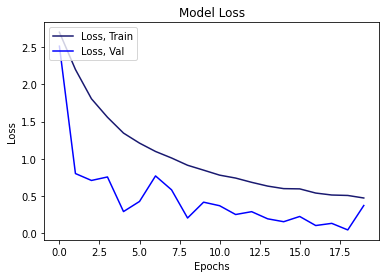

In [24]:
# plot the results
plt.plot(history.history['accuracy'], color='midnightblue', label='Accuracy, Train')
plt.plot(history.history['val_accuracy'], color='blue', label='Accuracy, Val')

plt.plot(history.history['top2_acc'], color='seagreen', label='Top 2, Train')
plt.plot(history.history['val_top2_acc'], color='springgreen', label='Top 2, Val')

plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# plot the results
plt.plot(history.history['loss'], color='midnightblue', label='Loss, Train')
plt.plot(history.history['val_loss'], color='blue', label='Loss, Val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

In [25]:
# use the best saved model from the callback
model = load_model('best_model.h5', custom_objects={'top2_acc': top2_acc})

## Step 7 - Predict

#### Test Set Predictions

Now make predictions on the test set and display the results.

In [26]:
predictions = model.predict(test_set)
predicted_classes = np.argmax(predictions, axis=-1)
actual_classes = test_set.classes

In [27]:
print(classification_report(actual_classes, predicted_classes, target_names=CLASSES))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.78      0.78      0.78        18
  apu_nahasapeemapetilon       0.86      0.67      0.75        18
            bart_simpson       0.76      0.72      0.74        18
charles_montgomery_burns       1.00      0.61      0.76        18
            chief_wiggum       0.88      0.83      0.86        18
          comic_book_guy       0.75      0.83      0.79        18
          edna_krabappel       0.87      0.72      0.79        18
           homer_simpson       0.52      0.89      0.65        18
           kent_brockman       1.00      0.83      0.91        18
        krusty_the_clown       0.75      1.00      0.86        18
            lisa_simpson       0.70      0.78      0.74        18
           marge_simpson       0.94      0.89      0.91        18
     milhouse_van_houten       0.79      0.83      0.81        18
             moe_szyslak       0.74      0.78      0.76        18
         

In [28]:
top_2_classes = np.argsort(-predictions, axis=1)[:, :2]
top_2_correct = [actual_classes[i] in top_2_classes[i] for i in range(len(actual_classes))]
top_2_acc = sum(top_2_correct)/len(actual_classes)

print('Accuracy = {0}'.format(round(accuracy_score(actual_classes, predicted_classes),2)))
print('Top-2 Accuracy = {0}'.format(round(top_2_acc,2)))

Accuracy = 0.78
Top-2 Accuracy = 0.9


#### Confusion matrix

In [29]:
cm = pd.DataFrame(confusion_matrix(actual_classes, predicted_classes), index=class_indices.keys(), columns=class_indices.keys())
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

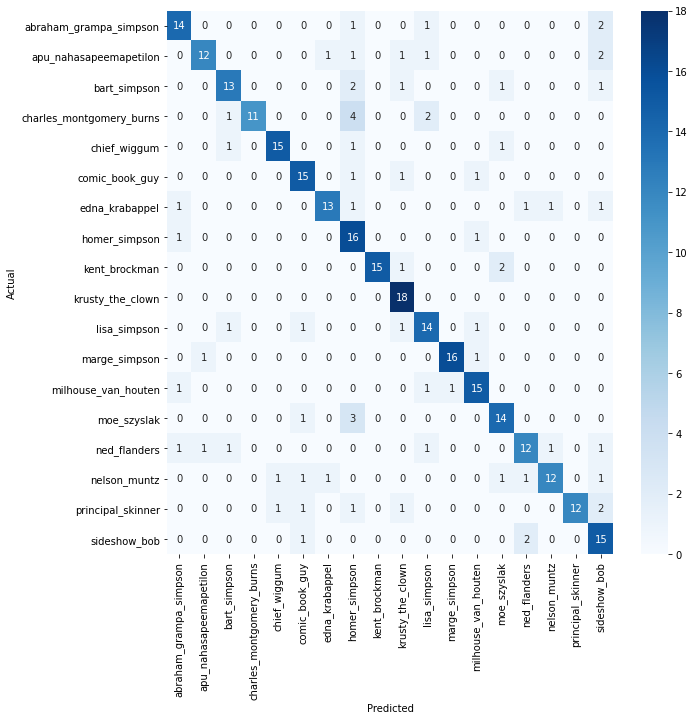

In [30]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Single Image Predictions

Do a final test on the model by predicting some images from google (completely outside of the original dataset).

In [31]:
def predict_single_img(model, img_path):

    test_img = image.load_img(img_path, target_size=(IMG_DIM,IMG_DIM))
    img_plt = plt.imshow(test_img)
    
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis=0)
    
    predictions = model.predict(test_img)
    return np.argmax(predictions, axis=-1)[0]

The character below is homer_simpson


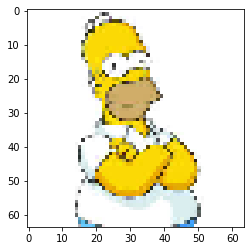

The character below is krusty_the_clown


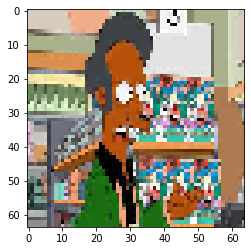

The character below is sideshow_bob


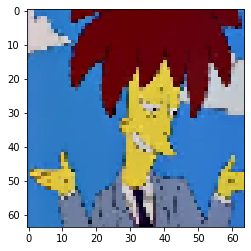

The character below is lisa_simpson


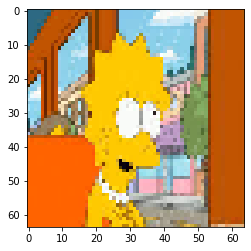

The character below is chief_wiggum


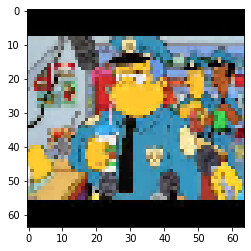

In [32]:
# predict some single images

test_root = './datasets/test_new/'
test_images = ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']

for test_img in test_images:

    plt.imshow(image.load_img(test_root+test_img))
    
    prediction = predict_single_img(model, test_root+test_img)
    
    print("The character below is {0}".format(CLASSES[prediction]))
    plt.show()